#Lecture 9: 2D Convolutional Networks

2D convolutional networks are primarily used for processing image data.  Image sequences are videos, so signal processing in this case is looking at sequences of images where the sequence matters.  If you are seeing sequences of dogs and just trying to see when one is or is not in the picture, that is not really a timeseries problem.  But if you are trying to figure out how fast the dog is moving, then that is a timeseries problem because it depends on the precise timing of the input images.

Here we are going to look at thhe problem of estimating movement from images.  In general, different things within an image will move at different speeds.  When everything moves at the same speed, then it is likely that the observer herself is moving.  So the "background" movement gives the "self movement", whereas foreground movement in small regions tends to be the movement of objects.  Movement can be represented as a series of little vectors all over the image that indicate where each part of the image is moving to in the subsequent frame.  The length of the little vectors indicates the local speed.

If we think of a video sequence as a time-varying image $f(x,t)$ where here $x$ is the spatial location, $t$ is time, and $f(x,t)$ is the intensity of the image at that location at that point in time, then we can use the chain rule of differentiation to write
\begin{equation}
  \frac{df}{dt} =  \frac{\partial f}{\partial x}\cdot \frac{dx}{dt}
\end{equation}
$dx/dt$ is the speed of image movement at that location.  Actually, it is the negative of speed, because if $x(t)$ is increasing, then the image $f(x(t),t)$ is seeing things that are coming from the right, so it is as if the image itself is sliding left.  So we typically write
\begin{equation}
  \frac{df}{dt} =  -v(x,t) \frac{\partial f}{\partial x}
\end{equation}
where $v$ is the velocity of the image at point $x$ at time $t$.  This is the equation for "optical flow", and it suggests that we can find the local image velocity $v$ by dividing the rate of change of intensity at a point $df/dt$ by the rate of change of intensity as we move across the image $\partial f / \partial x$.  In discrete time/space, we would have:  
\begin{equation}
  v(x,t) = -\frac{f(x,t)-f(x,t-1)}{f(x,t) - f(x-1,t)}
\end{equation}
If we want to find the overall image flow (self movement) then we would use the average speed over all pixels: $v_{self}(t) = E_x[v(x,t)]$.

We are not actually going to do it this way, but I wanted you to know the correct answer.  What we are going to do is notice that all the information needed to calculate $v(x,t)$ lies in the two images $f(x,t)$ and $f(x,t-1)$.  Therefore we will provide these two images as input to the network, and let the network learn the self motion $v_{self}(t)$ any way that it can.  To solve this requires approximating the division operator, so a typical network that uses a sigmoid or relu nonlinearity will have to do some work to make this happen.



In [20]:
#The usual preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import cv2
from moviepy.editor import *


import seaborn as sns
import tensorflow as tf

#for your homework
np.random.seed(10327798)
tf.random.set_seed(10327798)


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This is not a very interesting video; I recorded it at CHOC.  Wanted a background with lots of texture.  The reason is that an image that has regions with no texture (eg: a white wall) will make $\partial f / \partial x$ very small in those regions. If the network tries to solve this using division, it will get a divide by zero error (or a very large unstable numerical output).  The reason this occurs is that optical flow is undefined in flat regions of the image.  Normally you might assign a confidence value to regions depending on how much texture (variation) there is.  In our case we sidestep this by using images that have good texture everywhere.

In [22]:
video_filename = '/content/drive/MyDrive/Colab Notebooks/CHOCVideo2.mov'
video_reader = cv2.VideoCapture(video_filename)


Width = 640, Height = 360, Colors = 3


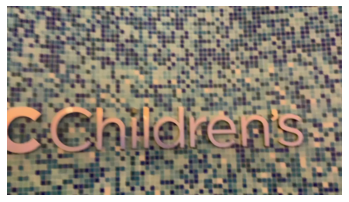

In [23]:
_, bgr_frame = video_reader.read()
rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)  #convert to RGB order for processing
plt.imshow(rgb_frame)
plt.axis('off')
orig_width = bgr_frame.shape[1]
orig_height = bgr_frame.shape[0]
ncolors = bgr_frame.shape[2]
image_width = 128
image_height = np.int(orig_height * image_width / orig_width)  #proportional scaling to preserve aspect ratio
print(f'Width = {orig_width}, Height = {orig_height}, Colors = {ncolors}')


Now we do two things.  First is that we resize to something small which will make the processing much faster.  Remember that we will do convolutions for every input sample, so the smaller the sample the faster these convolutions will go.  If you implement convolutions using FFT, then the time grows as nlogn which isn't bad.  I suspect that Keras/Tensorflow do not use FFTs, in which case convolution time grows as $n^2$ with image width $n$.  

Also we do a trick here with the time.  I want the network to have access to both $f(x,t)$ and $f(x,t-1)$.  I could do this using TimeSeriesGenerator to provide two inputs.  However, Keras/TF will then treat each of the two inputs as completely separate and will calculate the input basis for each separately.  I want an input basis that combines both images.  In other words, the first layer of the network should look like:
\begin{equation}
  y_{ij} = \sum_{ij} w_{0ij} f(ij,t) + \sum_{ij} w_{1ij}f(ij,t-1)
\end{equation}
where $w_{0ij}$ and $w_{1ij}$ are the weights to the $ij$'th image location for the image at time $t$ and time $t-1$ respectively.  In other words, the kernels will combine the past two images at each location.  The idea is that the network will be able to learn an approximation to the time derivative $f(x,t)-f(x,t-1)$.  

Therefore what I do here is take the 3-dimensional images (1 dimension for each color) and stack them to get a 6-dimensional image (1 dimension for each color at each of two times).  Keras/TF will just think this is a "multispectral" image (eg: radar)

In [24]:
frames_list = []
nframes = 0
while True:
  success, bgr_frame = video_reader.read()
  if not success:
    break
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)   #RGB color conversion
  resized_frame = cv2.resize(rgb_frame, (image_width, image_height))  #resize and smooth to make smaller
  normalized_frame = resized_frame / 255
  if nframes > 0:
    last_frame = np.append(last_frame, normalized_frame, axis=2)   #append along the color axis to make a double frame
    frames_list.append(last_frame)
    last_frame = normalized_frame.copy()
  if nframes == 0:
    last_frame = normalized_frame.copy()
  nframes +=1
video_reader.release()
print(f'Read {nframes} frames')


Read 1844 frames


(72, 128, 6)

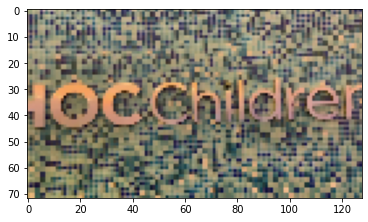

In [25]:
plt.figure()
plt.imshow(frames_list[200][:,:,0:3]);   #note that to display we need to select one of the two images 0:3 or 3:6
frames_list[200].shape

I shot the video using my ipad, with my iphone held against it.  The iphone was running the "Gyro" app which records from all the sensors, while the ipad was recording video.  I exported the gyroscope rotational data in all 3 axes as I rotated the ipad camera.  So the gyro data indicate the actual camera movement that corresponds to the average optic flow in the image.

In [26]:
dfGyro = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/gyro.csv')
dfGyro = dfGyro.rename(columns={
    'Time' : 't',
    ' Rotation Rate (X)' : 'wx', 
    ' Rotation Rate (Y)' : "wy", 
    ' Rotation Rate (Z)' : "wz"})   #data record at 30Hz, which is same as video frame rate
dfGyro['t'] = dfGyro['t'] - dfGyro['t'][0]  #set the initial time to be zero
dfGyro

,t,wx,wy,wz
0,0.00000,0.099509,-0.028426,-0.044815
1,0.03334,-0.003392,0.011171,-0.077364
2,0.06667,0.095900,-0.036499,-0.057394
3,0.10000,0.339899,-0.068623,0.027582
4,0.13334,0.290086,0.027662,0.018464
...,...,...,...,...
1832,61.05606,0.019010,0.038634,-0.068281
1833,61.08941,0.092307,-0.020316,0.006578
1834,61.12276,0.033317,-0.014301,0.038383
1835,61.15614,-0.001969,-0.004178,-0.023021


(1837, 2)

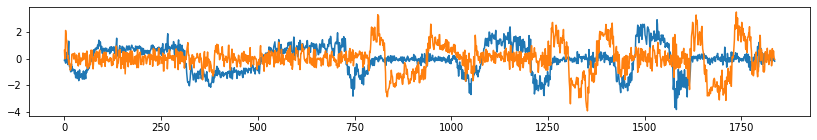

In [27]:
#predict both the horizontal and vertical gyro
desired_output_horizontal = dfGyro['wy'] / dfGyro['wy'].std()   #normalize so the network can learn
desired_output_vertical = dfGyro['wx'] / dfGyro['wx'].std()
desired_output = np.vstack((desired_output_horizontal.values, desired_output_vertical.values)).transpose()  #make column-wise

#make a list of the video frames that has the timestamps
nTimes, nOutputs = desired_output.shape  #in this case, the gyro data is slightly shorter than the video data
frames_list = frames_list[:nTimes]       #trim the video to be exactly the length of the gyro
      #to be safe, I checked first that the video length and gyro data length were the same; never trust the stated frame rate
imSeries = pd.Series(data=frames_list, index=dfGyro['t'])   #assigns timestamps to the video data in case we need that

plt.figure(figsize=(14,2))
plt.plot(desired_output);   #the gyro data are quite noisy.  I don't both filtering it; the network has to figure this out.
desired_output.shape


In [28]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 1
batch_size = 1
training_set_size = np.int(0.9 * nTimes)
test_set_size = nTimes - training_set_size
generator = TimeseriesGenerator(frames_list, desired_output, length = predict_length, batch_size=batch_size)
training_generator = TimeseriesGenerator(frames_list[:training_set_size], desired_output[:training_set_size,:], length = predict_length, batch_size=batch_size)
validation_generator = TimeseriesGenerator(frames_list[:-test_set_size], desired_output[:-test_set_size,:], length = predict_length, batch_size=batch_size)

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

#note the shape of the output:  (batch_size, predict_length, height, width, colorchannels)
generator[100][0].shape

(1, 1, 72, 128, 6)

In [29]:
#compare to the raw frames that go into this
frames_list[100].shape

(72, 128, 6)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 72, 128, 40)       6040      
                                                                 
 conv2d_19 (Conv2D)          (None, 72, 128, 20)       820       
                                                                 
 conv2d_20 (Conv2D)          (None, 72, 128, 20)       420       
                                                                 
 conv2d_21 (Conv2D)          (None, 72, 128, 2)        42        
                                                                 
 reshape_2 (Reshape)         (None, 72, 128, 2)        0         
                                                                 
 global_average_pooling2d_4   (None, 2)                0         
 (GlobalAveragePooling2D)                                        
                                                      

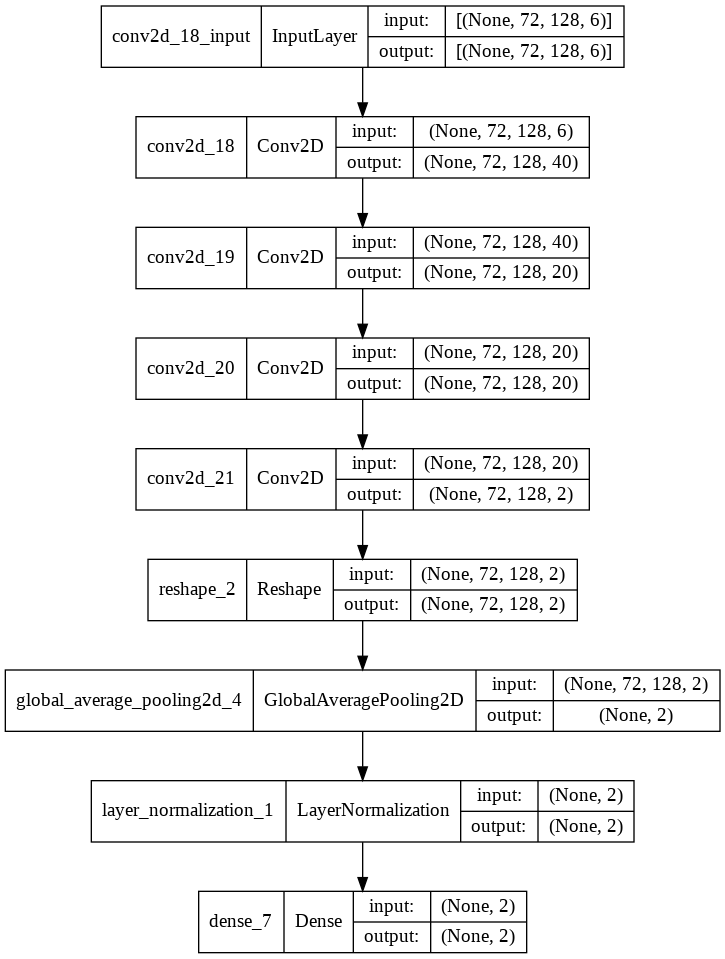

In [30]:
#build the network
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Reshape, LayerNormalization
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D  #useful for combining the outputs of convolution layers

len_conv_window = 5            #how many points in the convolution kernel in both x and y directions
n_conv_units = 40              #how many different convolution kernels h_i 
n_conv_units2 = 20              #how many different convolution kernels h_i 
n_sensors = 3                  #3 colors at each point.   could be multi-spectral, sensors, etc.
n_time_images = 2

model = Sequential()
#first layer creates a 20 5x5 spatial filters and convolves each with the input
model.add(Conv2D(filters = n_conv_units, 
                kernel_size = (len_conv_window, len_conv_window),  #these are the spatial filter kernels
                activation = 'sigmoid',
                #input_shape = (batch_size, predict_length, image_height, image_width, n_sensors*n_time_images),
                input_shape = (image_height, image_width, n_sensors*n_time_images),  #use when predict_length=1, batch_size=1
                padding = 'same'))
#second layer creates nonlinear combinations of the 20 spatial filters at each point to create a nonlinear basis
model.add(Conv2D(filters = n_conv_units2, 
                kernel_size = (1, 1),     #computation at each pixel location
                activation = 'sigmoid',
                padding = 'same',
                data_format="channels_last"))
#third layer gives more nonlinearity at each pixel
model.add(Conv2D(filters = n_conv_units2, 
                kernel_size = (1, 1),     #computation at each pixel location
                activation = 'sigmoid',
                padding = 'same',
                data_format="channels_last"))
#fourth layer estimates the local optic flow
model.add(Conv2D(filters = nOutputs,             #just two outputs, so we get vx and vy
                kernel_size = (1, 1),     #computation at each pixel location
                activation = 'sigmoid',
                padding = 'same',
                data_format="channels_last"))
#pooling layer says that we want to take the average of the local velocities  E[vx], E[vy]
force_local_estimate = True
if force_local_estimate:
  model.add(Reshape((image_height, image_width, nOutputs)))   #needed for the Pooling operation
  model.add(GlobalAveragePooling2D())  #averages over everything but the last input dimension
  model.add(LayerNormalization(axis=-1 , center=True , scale=True))  #average has low power.  this increases power into a good range for learning
else:
  model.add(Flatten())  #so that the linear layer produces a single set of outputs
model.add(Dense(nOutputs, activation='linear'))  #last layer will scale the output back up because average will be small
model.compile(optimizer='adam', loss='mse')
model.summary()
plot_model(model, show_shapes = True, show_layer_names = True)

Epoch 1/5
1652/1652 [==============================] - 74s 43ms/step - loss: 0.9920 - val_loss: 0.9565
Epoch 2/5
1652/1652 [==============================] - 63s 38ms/step - loss: 0.9661 - val_loss: 0.9626
Epoch 3/5
1652/1652 [==============================] - 64s 39ms/step - loss: 0.9607 - val_loss: 0.9571


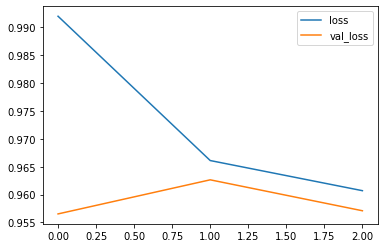

In [31]:
model.fit(training_generator, 
          epochs=5,
          validation_data=validation_generator,
          callbacks=[early_stop])
losses = pd.DataFrame(model.history.history)
losses.plot()

In [32]:
predicted_output = model.predict(generator)
dfPredict = pd.DataFrame(data=predicted_output)
nPredict,_  = dfPredict.shape

In [33]:
dfPredict
predicted_output[1:10,:]  #note that the scale is wrong.  

array([[-0.03926899,  0.06143779],
       [-0.03923999,  0.0614142 ],
       [-0.03918653,  0.06137186],
       [-0.03914994,  0.06134353],
       [-0.03915596,  0.06134769],
       [-0.03910711,  0.06130963],
       [-0.03908651,  0.06129399],
       [-0.03909389,  0.06129851],
       [-0.03907266,  0.06128301]], dtype=float32)

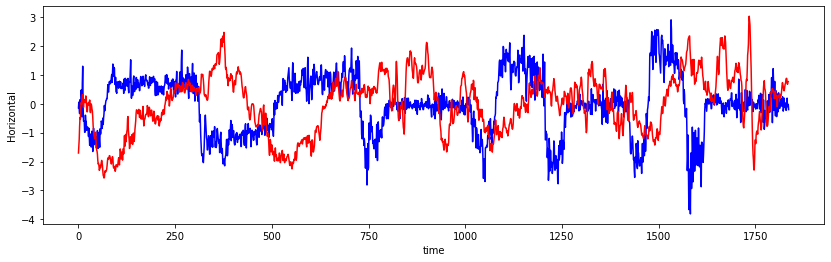

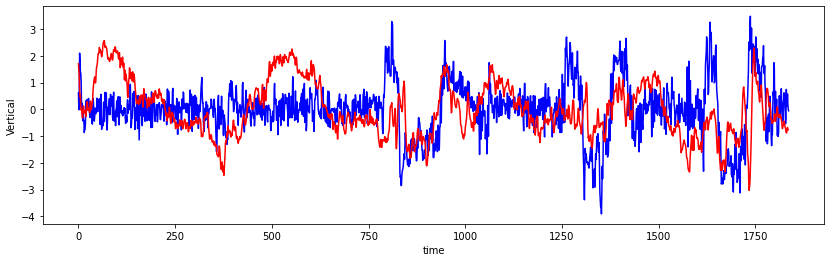

In [34]:
predict = dfPredict.values.copy()   #do not have to do ML or MMSE calculation here
predict -= dfPredict.mean()
predict /= dfPredict.std()    #should not have to do this

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(desired_output[:,0],'b')  #compare one column at a time
plt.plot(predict[:,0],'r')
plt.ylabel('Horizontal')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(desired_output[:,1],'b')  #compare one column at a time
plt.plot(predict[:,1],'r')
plt.ylabel('Vertical')
plt.xlabel('time');




In [35]:
rms_error = np.sqrt(np.sum(np.mean(np.square(predict-desired_output[:nPredict,:]))))
print('Scalar output rms_error {}'.format(rms_error));

Scalar output rms_error 1.4206812515066516


In [36]:
w=model.weights[0][:,:,3,1]
np.max(w)

0.11713341